## Python statistics essential training - 04_04_testing

Standard imports

In [292]:
import math
import io

In [293]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as pp

%matplotlib inline

In [294]:
import scipy.stats
import scipy.optimize
import scipy.spatial

In [295]:
# pp.style.use('ggplot')
mpl.rcParams.update(mpl.rcParamsDefault)

In [296]:
pumps = pd.read_csv('pumps.csv')
pumps

,lat,lon,x,y
0,51.513341,-0.136668,0.000000,0.000000
1,51.513876,-0.139586,-0.201858,0.059469
2,51.514906,-0.139671,-0.207738,0.173961
3,51.512354,-0.131630,0.348513,-0.109712
4,51.512139,-0.133594,0.212650,-0.133611
5,51.511542,-0.135919,0.051813,-0.199972
6,51.510019,-0.133962,0.187193,-0.369265
7,51.511295,-0.138199,-0.105910,-0.227428


In [297]:
cholera = pd.read_csv('cholera.csv')
cholera.loc[0::20]

,deaths,lat,lon,x,y,closest
0,3,51.513418,-0.137930,-0.087301,0.008559,0
20,2,51.513441,-0.138762,-0.144856,0.011116,1
40,2,51.513025,-0.139036,-0.163811,-0.035126,1
60,1,51.512765,-0.137533,-0.059838,-0.064027,0
80,1,51.512782,-0.136819,-0.010446,-0.062137,0
100,4,51.512250,-0.135394,0.088131,-0.121273,5
120,1,51.513238,-0.134594,0.143473,-0.011449,4
140,1,51.512585,-0.134793,0.129707,-0.084035,4
160,1,51.514065,-0.134364,0.159384,0.080478,0
180,1,51.515149,-0.135395,0.088062,0.200973,0


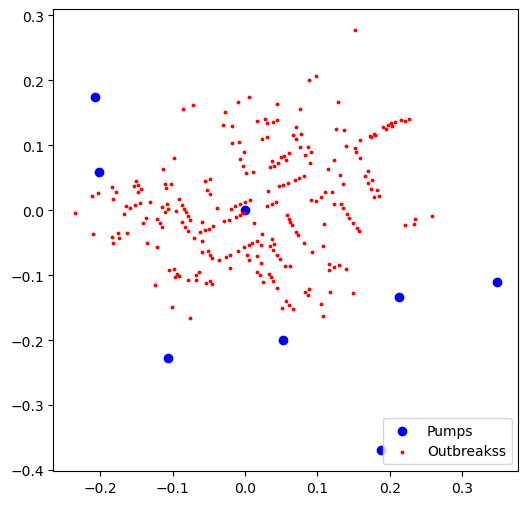

In [298]:
pp.figure(figsize=(6,6))
ax = pp.axes()
# ax.set_facecolor("black")
ax.scatter(pumps.x,pumps.y,color='b')
ax.scatter(cholera.x,cholera.y,color='r',s=3)
_ = pp.legend(('Pumps', 'Outbreakss'), loc='lower right')

In [299]:
img = mpl.image.imread('london.png')


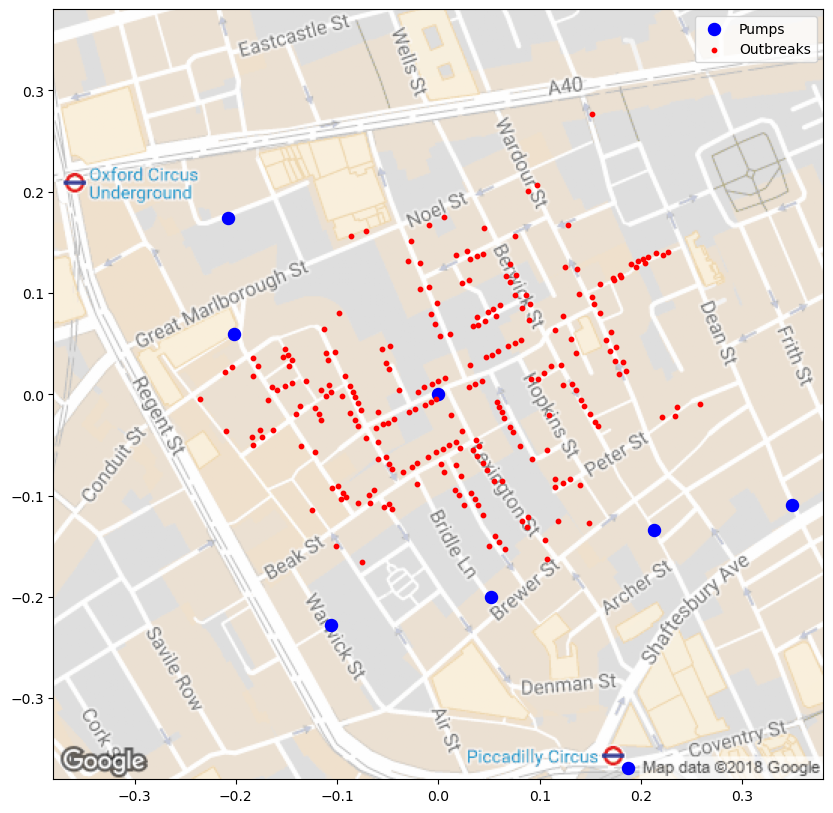

In [300]:
pp.figure(figsize=(10,10))

pp.imshow(img,extent=[-0.38,0.38,-0.38,0.38])
pp.scatter(pumps.x,pumps.y,color='blue', s=75)
pp.scatter(cholera.x,cholera.y,color='r',s=10)
pp.legend(('Pumps', 'Outbreaks'), loc='upper right');

#### how many rows for each pump (closest == the number of the closest pump

In [301]:
# how many ROWS for each pump (closest == the number of the closest pump
cholera.closest.value_counts()

0    171
1     36
4     19
5     13
7      9
2      2
Name: closest, dtype: int64

#### how many DEATHS for each pump (closest == the number of the closest pump

In [302]:
(cholera.groupby('closest').deaths.sum()).sort_values(ascending=False)

closest
0    340
1     65
4     40
5     27
7     12
2      5
Name: deaths, dtype: int64

create a simulation that creates n samples based on the population distribution in the geographic areas
Use random.choice() toscramble

In [303]:
def simulate(n):
    # n is the number of replicates
    populations = [0.65, 0.15, 0.10, 0.10]  # pre-calculated population density near each pump (0,1,4,5)
    return pd.DataFrame({'closest': np.random.choice([0,1,4,5],size=n, p=populations)})

In [304]:
# try our simulation  a test df of just 5 rows with the pre-set population probabilities
simulate(5).sort_values(ascending=True, by='closest')

,closest
0,0
1,0
2,0
3,0
4,0


#### run simulations one for each death using the population-based simulate() func

In [305]:
# group the outputs so we can see which pumps have the most incidents
total_deaths = cholera.deaths.sum()

print("This looks similar to the observed data, so the population may have as much impact as proximity to any given pump")
simulate(total_deaths).closest.value_counts()

This looks similar to the observed data, so the population may have as much impact as proximity to any given pump


0    298
1     84
5     59
4     48
Name: closest, dtype: int64

#### run the same simulation 10_000 times, getting just the rows having the zero pump population density
The NULL Hypotheses is that pumps have nothing to do with Cholera deaths
and that deaths occurred simply proportionally to population density

to do this we look at just the empirical population around pump 0
there were 489 observed deaths total, and 340 of those were near pump 0


Run 10,000 simulations, each having 489 deaths, and weight them by population density (using the umps as an anchor for population weights)

In [306]:
# runs for four pumps but FILTER out only pump 0 data
sampling = pd.DataFrame({'counts': [simulate(489).closest.value_counts()[0] for i in range(10_000)]})

Simulated deaths based on population density - for only the area near pump 0
These are mostly less than the observed value of 340


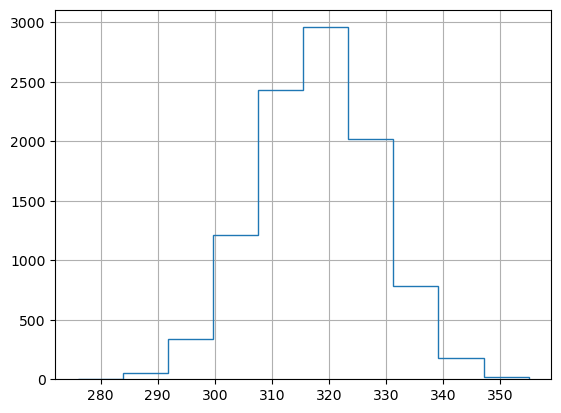

In [314]:
print("Simulated deaths based on population density - for only the area near pump 0")
sampling.counts.hist(histtype='step');
print("These are mostly less than the observed value of 340")

##### compare our smulated values to the empirical observed facts


In [308]:
deaths_near_pump_zero = cholera.loc[(cholera.closest == 0), 'deaths'].sum()

print(f"There were {deaths_near_pump_zero} observed deaths near pump zero")
print(f"We want to see what percentile {deaths_near_pump_zero} deaths occurred in our NULL hypothesis")

There were 340 observed deaths near pump zero
We want to see what percentile 340 deaths occurred in our NULL hypothesis


##### Compare observed with simulation

In [309]:
pos = scipy.stats.percentileofscore(sampling.counts, kind='strict', score=340)

In [310]:
print("The Null Hypothesis was that deaths had more to do with population than the pump itself")
print("To do this we got samples ")
print(f"we get {deaths_near_pump_zero} at the far percentile {pos} ")
print(f"this means that {pos} percent of the points are below {deaths_near_pump_zero} ")
print(f"We would expect to get {deaths_near_pump_zero} only {(100 - pos)/100}% of the time")


The Null Hypothesis was that deaths had more to do with population than the pump itself
To do this we got samples 
we get 340 at the far percentile 98.0 
this means that 98.0 percent of the points are below 340 
We would expect to get 340 only 0.02% of the time


# The Null hypothesis
- The null hypothesis states that two measured phenomena experience no relationship to each other.
- For a significance level of 5%, if the p-value falls lower than 5%, the null hypothesis is invalidated.
- Note that p-values can range from 0% to 100% and we write them in decimals. A p-value for 5% will be 0.05.
- A smaller p-value bears more significance as it can tell you that the hypothesis may not explain the observation fairly.
If one or more of these probabilities turn out to be less than or equal to α, the level of significance, we reject the null hypothesis.

In [311]:
img2 = mpl.image.imread('pvalue.png')

For a true null hypothesis, p can take on any value between 0 and 1 with equal likeliness. 
For a true ALTERNATE hypothesis, p-values likely fall closer to 0


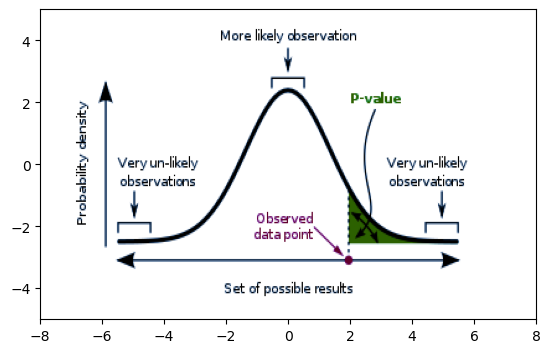

In [315]:
pp.imshow(img2,extent=[-8,8,-5,5]);
print("For a true null hypothesis, p can take on any value between 0 and 1 with equal likeliness. ")
print("For a true ALTERNATE hypothesis, p-values likely fall closer to 0")